In [1]:
import os
import numpy as np
from bct import modularity

from clique import Clique
from itertools import combinations
import matplotlib.pylab as plt

In [2]:
def load_group_files(base_url, group_path):
    path = '{}/{}/'.format(base_url, group_path)
    file_names = sorted(os.listdir(path))
    files = ['{}{}'.format(path, elem) for elem in file_names]
    return files

def load_matrix_subjects(base_url, group_path):
    group_files = load_group_files(base_url, group_path)
    return _load_matrix_subject_with_files(group_files)

def _load_matrix_subject_with_files(files):
    subjects = []
    for file in files:
        mat = np.loadtxt(file, delimiter=' ')
        np.fill_diagonal(mat, 0)
        subjects.append(mat)
    return np.array(subjects)

In [3]:
def measure_edge_weight(aff, mat, edge_combo):
    inter_weight = 0
    intra_weight = 0

    intra_count = 0
    inter_count = 0

    for e in edge_combo:
        if aff[e[0]] == aff[e[1]]:
            intra_weight += mat[e]
            if mat[e] != 0:
                intra_count += 1
        else:
            inter_weight += mat[e]
            if mat[e] != 0:
                inter_count += 1

    inter_ratio = inter_weight / np.sum(mat) * 2
    intra_ratio = intra_weight / np.sum(mat) * 2

    print(f'# of inter-edges: {inter_count}; # of intra-edges: {intra_count}')
    print(f'inter-edge ratio: {inter_ratio:.4f}; intra-edge ratio: {intra_ratio:.4f}')
    print(f'total inter-edge weight: {inter_weight:.4f}; total intra-edge weight: {intra_weight:.4f}')
    # return inter_ratio, intra_ratio

In [7]:
data_type = 'correlation'
datasets = ['adolescents', 'children', 'eyesclosed', 'male', 'female', 'complete_abide']

n_nodes = 116
edge_combo = list(combinations(range(n_nodes), 2))

In [8]:
idx = 1

In [9]:
dataset = datasets[idx]

diff_mat = np.loadtxt(f"../abide_datasets/{data_type}_diff_mat/{dataset}/td_asd_diff_mat_whole_dataset.txt")

td_subjects = load_matrix_subjects(f'../abide_datasets/{data_type}/{dataset}', 'td')
asd_subjects = load_matrix_subjects(f'../abide_datasets/{data_type}/{dataset}', 'asd')

td_mean = np.mean(td_subjects, axis=0)
asd_mean = np.mean(asd_subjects, axis=0)

td_positive_mean = td_mean * (td_mean > 0)
td_negative_mean = td_mean * (td_mean < 0)
asd_positive_mean = asd_mean * (asd_mean > 0)
asd_negative_mean = asd_mean * (asd_mean < 0)

td_asd_edges = Clique.create_cliques(edge_combo, td_mean - asd_mean)
sorted_edge_indices = np.flip(np.argsort(td_asd_edges))

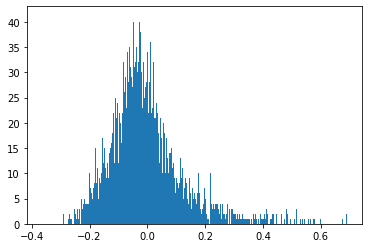

In [10]:
plt.hist(list(map(lambda x: x.metric, Clique.create_cliques(edge_combo, td_mean))), bins=1000);

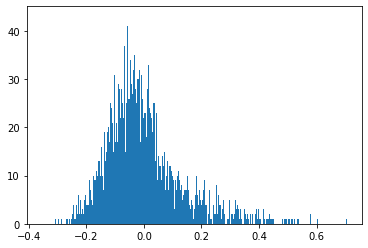

In [11]:
plt.hist(list(map(lambda x: x.metric, Clique.create_cliques(edge_combo, asd_mean))), bins=1000);

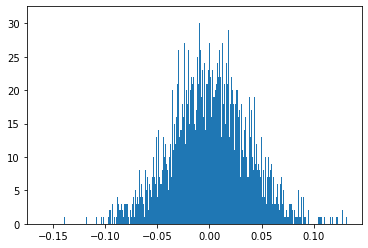

In [12]:
plt.hist(list(map(lambda x: x.metric, td_asd_edges)), bins=1000);

In [13]:
td_degrees = np.sum(td_positive_mean, axis=0)
asd_degrees = np.sum(asd_positive_mean, axis=0)

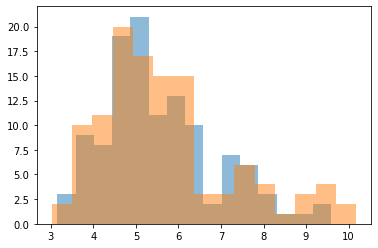

In [14]:
plt.hist(td_degrees, bins=15, alpha=.5);
plt.hist(asd_degrees, bins=15, alpha=.5);

In [15]:
seed = 50

In [16]:
td_ci, td_q = modularity.modularity_louvain_und_sign(td_mean, qtype='sta', seed=3)

print('positive edges:')
measure_edge_weight(td_ci, td_positive_mean, edge_combo)

print('\nnegative edges:')
measure_edge_weight(td_ci, td_negative_mean, edge_combo)

positive edges:
# of inter-edges: 1465; # of intra-edges: 1327
inter-edge ratio: 0.2927; intra-edge ratio: 0.7073
total inter-edge weight: 94.5812; total intra-edge weight: 228.5588

negative edges:
# of inter-edges: 3496; # of intra-edges: 382
inter-edge ratio: 0.9205; intra-edge ratio: 0.0795
total inter-edge weight: -294.3552; total intra-edge weight: -25.4173


In [17]:
count = 0
td_inter_edges = []
td_intra_edges = []
td_inter_edges_inclusion = []
td_freq_dict = {}
for i, e_idx in enumerate(sorted_edge_indices[:500]):
    e = td_asd_edges[e_idx].vertices

    path = (td_ci[e[0]], td_ci[e[1]])
    if path[0] > path[1]:
        path = (path[1], path[0])
    
    if td_ci[e[0]] != td_ci[e[1]]:
        if td_freq_dict.get(path) is None:
            td_freq_dict[path] = 0
        
        count += 1
        if td_mean[e] > 0:
            td_freq_dict[path] += td_mean[e]
            print(f'{i}, {td_asd_edges[e_idx]}, {(td_ci[e[0]], td_ci[e[1]])}, {td_mean[e]:.3f}, {asd_mean[e]:.3f}, td v0 degree: {np.sum(td_positive_mean[e[0], :]):.3f}, td v1 degree: {np.sum(td_positive_mean[e[1], :]):.3f}')
        td_inter_edges.append(td_mean[e])
    else:
        td_intra_edges.append(td_mean[e])
        # print(f'{i}, {td_asd_edges[e_idx]}, {(asd_td_ci[e[0]], asd_td_ci[e[1]])}, {td_mean[e]:.3f}')
    td_inter_edges_inclusion.append(count / (i + 1))

td_inter_edges = np.array(td_inter_edges)
td_intra_edges = np.array(td_intra_edges)

td_freq_dict

2, (53, 83), 0.127, (3, 1), 0.044, -0.083, td v0 degree: 3.625, td v1 degree: 4.937
6, (26, 41), 0.117, (2, 1), 0.054, -0.063, td v0 degree: 5.251, td v1 degree: 6.586
8, (19, 114), 0.115, (1, 4), 0.033, -0.082, td v0 degree: 3.569, td v1 degree: 3.866
25, (4, 83), 0.099, (2, 1), 0.055, -0.044, td v0 degree: 5.498, td v1 degree: 4.937
28, (52, 61), 0.096, (3, 2), 0.133, 0.036, td v0 degree: 3.979, td v1 degree: 4.983
32, (61, 100), 0.096, (2, 4), 0.158, 0.062, td v0 degree: 4.983, td v1 degree: 4.894
42, (28, 53), 0.093, (1, 3), 0.013, -0.080, td v0 degree: 9.074, td v1 degree: 3.625
43, (18, 82), 0.093, (1, 2), 0.205, 0.113, td v0 degree: 3.729, td v1 degree: 5.245
46, (29, 49), 0.092, (1, 3), 0.003, -0.089, td v0 degree: 9.285, td v1 degree: 4.801
57, (85, 94), 0.089, (2, 3), 0.027, -0.062, td v0 degree: 3.941, td v1 degree: 4.459
62, (19, 109), 0.088, (1, 3), 0.025, -0.063, td v0 degree: 3.569, td v1 degree: 5.121
63, (10, 83), 0.088, (2, 1), 0.072, -0.017, td v0 degree: 4.361, td v

{(1, 2): 3.2736855196746495,
 (1, 3): 1.3698846123763044,
 (1, 4): 0.6337303999584563,
 (2, 3): 1.4560078472695577,
 (2, 4): 2.346143766723629,
 (3, 4): 1.005716151904593}

In [18]:
np.sum(td_inter_edges < 0), np.sum(td_inter_edges > 0), len(td_inter_edges), np.sum(td_intra_edges < 0), np.sum(td_intra_edges > 0), len(td_intra_edges)

(216, 150, 366, 14, 120, 134)

In [19]:
np.sum(td_inter_edges[td_inter_edges < 0]), np.sum(td_inter_edges[td_inter_edges > 0]), np.sum(td_intra_edges[td_intra_edges < 0]), np.sum(td_intra_edges[td_intra_edges > 0])

(-16.414335224541453,
 10.085168297907192,
 -0.45474784202781154,
 18.961794106718052)

In [20]:
count = 0
asd_inter_edges = []
asd_intra_edges = []
asd_inter_edges_inclusion = []
asd_freq_dict = {}

for i, e_idx in enumerate(reversed(sorted_edge_indices[-500:])):
    e = td_asd_edges[e_idx].vertices

    path = (td_ci[e[0]], td_ci[e[1]])
    if path[0] > path[1]:
        path = (path[1], path[0])
    
    if td_ci[e[0]] != td_ci[e[1]]:
        if asd_freq_dict.get(path) is None:
            asd_freq_dict[path] = 0
        count += 1
        if asd_mean[e] > 0:
            asd_freq_dict[path] += asd_mean[e]
            print(f'{i}, {td_asd_edges[e_idx]}, {(td_ci[e[0]], td_ci[e[1]])}, {td_mean[e]:.3f}, {asd_mean[e]:.3f}, asd v0 degree: {np.sum(asd_positive_mean[e[0], :]):.3f}, asd v1 degree: {np.sum(asd_positive_mean[e[1], :]):.3f}')
        asd_inter_edges.append(asd_mean[e])
    else:
        asd_intra_edges.append(asd_mean[e])
        # print(f'{i}, {td_asd_edges[e_idx]}, {(asd_td_ci[e[0]], asd_td_ci[e[1]])}, {td_mean[e]:.3f}')
    asd_inter_edges_inclusion.append(count / (i + 1))

asd_inter_edges = np.array(asd_inter_edges)
asd_intra_edges = np.array(asd_intra_edges)

asd_freq_dict

4, (82, 106), -0.118, (2, 4), -0.068, 0.050, asd v0 degree: 4.894, asd v1 degree: 3.023
10, (10, 16), -0.108, (2, 1), 0.180, 0.288, asd v0 degree: 4.344, asd v1 degree: 7.617
13, (53, 114), -0.105, (3, 4), -0.050, 0.055, asd v0 degree: 4.142, asd v1 degree: 3.836
14, (17, 85), -0.104, (1, 2), -0.070, 0.034, asd v0 degree: 8.300, asd v1 degree: 3.921
17, (38, 95), -0.100, (1, 3), 0.094, 0.195, asd v0 degree: 7.313, asd v1 degree: 5.643
18, (53, 93), -0.099, (3, 4), -0.043, 0.057, asd v0 degree: 4.142, asd v1 degree: 5.980
19, (8, 49), -0.097, (2, 3), -0.063, 0.034, asd v0 degree: 4.697, asd v1 degree: 5.536
20, (3, 69), -0.097, (2, 4), -0.062, 0.034, asd v0 degree: 5.351, asd v1 degree: 3.992
21, (34, 51), -0.096, (2, 3), -0.083, 0.013, asd v0 degree: 3.740, asd v1 degree: 5.297
23, (51, 93), -0.096, (3, 4), -0.084, 0.012, asd v0 degree: 5.297, asd v1 degree: 5.980
24, (50, 114), -0.096, (3, 4), -0.070, 0.026, asd v0 degree: 4.775, asd v1 degree: 3.836
26, (64, 83), -0.095, (2, 1), -0.0

{(2, 4): 0.8190649798977193,
 (2, 3): 1.848815248856842,
 (1, 2): 5.558976554954975,
 (3, 4): 3.0333860804940445,
 (1, 3): 2.5193129604457005,
 (1, 4): 0.3490204686014192}

In [21]:
np.sum(asd_inter_edges < 0), np.sum(asd_inter_edges > 0), len(asd_inter_edges), np.sum(asd_intra_edges < 0), np.sum(asd_intra_edges > 0), len(asd_intra_edges)

(152, 172, 324, 23, 153, 176)

In [22]:
np.sum(asd_inter_edges[asd_inter_edges < 0]), np.sum(asd_inter_edges[asd_inter_edges > 0]), np.sum(asd_intra_edges[asd_intra_edges < 0]), np.sum(asd_intra_edges[asd_intra_edges > 0])

(-11.343608773564824,
 14.1285762932507,
 -1.4182730767847225,
 34.797182951342506)

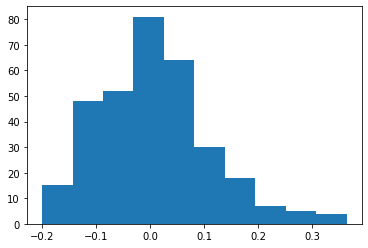

In [23]:
plt.hist(asd_inter_edges);

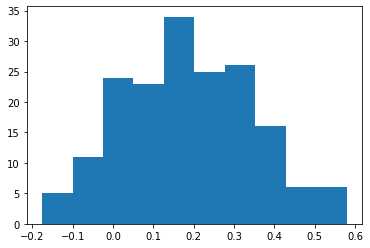

In [24]:
plt.hist(asd_intra_edges);

In [26]:
asd_ci, asd_q = modularity.modularity_louvain_und_sign(asd_mean, qtype='sta', seed=seed)

print('negative edges:')
measure_edge_weight(asd_ci, td_mean * (td_mean < 0), edge_combo)

print('\npositive edges:')
measure_edge_weight(asd_ci, td_mean * (td_mean > 0), edge_combo)

negative edges:
# of inter-edges: 3143; # of intra-edges: 735
inter-edge ratio: 0.8290; intra-edge ratio: 0.1710
total inter-edge weight: -265.0874; total intra-edge weight: -54.6852

positive edges:
# of inter-edges: 1234; # of intra-edges: 1558
inter-edge ratio: 0.2390; intra-edge ratio: 0.7610
total inter-edge weight: 77.2311; total intra-edge weight: 245.9088


In [27]:
count = 0
inter_edges = []
intra_edges = []
inter_edges_inclusion = []
for i, e_idx in enumerate(reversed(sorted_edge_indices[-500:])):
    e = td_asd_edges[e_idx].vertices
    
    if asd_ci[e[0]] != asd_ci[e[1]]:
        count += 1
        # if asd_mean[e] > 0:
        print(f'{i}, {td_asd_edges[e_idx]}, {(asd_ci[e[0]], asd_ci[e[1]])}, {asd_mean[e]:.3f}, {td_mean[e]:.3f}')
        inter_edges.append(asd_mean[e])
    else:
        intra_edges.append(asd_mean[e])
        # print(f'{i}, {td_asd_edges[e_idx]}, {(asd_td_ci[e[0]], asd_td_ci[e[1]])}, {td_mean[e]:.3f}')
    inter_edges_inclusion.append(count / (i + 1))

inter_edges = np.array(inter_edges)
intra_edges = np.array(intra_edges)

np.sum(inter_edges < 0), np.sum(inter_edges > 0), len(inter_edges), np.sum(intra_edges < 0), np.sum(intra_edges > 0), len(intra_edges)

4, (82, 106), -0.118, (2, 3), 0.050, -0.068
8, (4, 43), -0.110, (1, 3), -0.053, -0.163
12, (13, 22), -0.107, (2, 1), -0.045, -0.152
14, (17, 85), -0.104, (2, 1), 0.034, -0.070
19, (8, 49), -0.097, (1, 3), 0.034, -0.063
20, (3, 69), -0.097, (1, 2), 0.034, -0.062
21, (34, 51), -0.096, (1, 3), 0.013, -0.083
26, (64, 83), -0.095, (1, 2), 0.005, -0.090
28, (51, 66), -0.095, (3, 2), 0.103, 0.008
32, (0, 64), -0.093, (2, 1), -0.016, -0.109
33, (45, 69), -0.093, (3, 2), -0.026, -0.118
34, (36, 95), -0.091, (2, 3), 0.183, 0.092
36, (83, 89), -0.091, (2, 1), 0.072, -0.019
37, (34, 48), -0.091, (1, 3), 0.033, -0.058
38, (9, 49), -0.090, (1, 3), 0.042, -0.048
44, (4, 47), -0.089, (1, 3), -0.058, -0.147
47, (2, 48), -0.089, (1, 3), 0.068, -0.021
50, (50, 64), -0.088, (3, 1), 0.137, 0.049
52, (45, 67), -0.088, (3, 1), 0.337, 0.248
53, (61, 65), -0.088, (2, 1), 0.398, 0.310
54, (37, 55), -0.088, (2, 3), 0.315, 0.227
55, (16, 88), -0.087, (2, 1), -0.113, -0.200
58, (1, 88), -0.087, (2, 1), 0.012, -0.0

(133, 117, 250, 42, 208, 250)

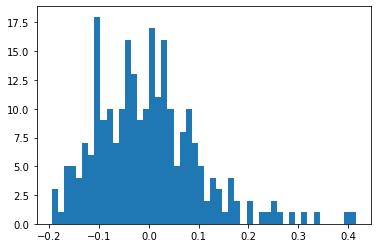

In [28]:
plt.hist(inter_edges, bins=50);

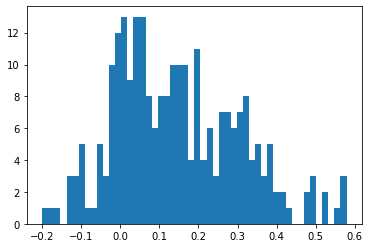

In [29]:
plt.hist(intra_edges, bins=50);

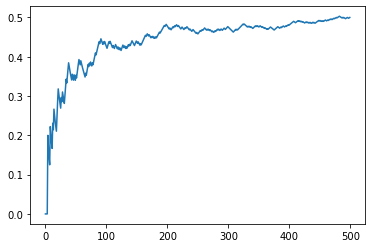

In [30]:
plt.plot(inter_edges_inclusion)